In [1]:
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import to_categorical

import cv2

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(28, 28)
        plt.imshow(image, cmap='gray')
        plt.title(labels[idx])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [3]:
def show_random_diff(ds_raw, ds_processed, labels, h=5, w=5):
    assert ds_raw.shape == ds_processed.shape
    
    idxs = np.random.randint(0, ds_raw.shape[0] - 1, size=w * h).tolist()
    plt.figure(figsize=(3 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = np.hstack([ds_raw[idx].reshape(28, 28),
                           ds_processed[idx].reshape(28, 28)])
        plt.imshow(image, cmap='gray')
        plt.title(labels[idx])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [4]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(28, 28) * 255.
        image = image.astype(np.uint8)
        plt.imshow(image, cmap='gray')
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [5]:
def show_random_predictions(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(28, 28, 1)
        plt.imshow(image, cmap='gray')
        plt.title(labels[idx])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [6]:
def deskew_image(pixels):
    SZ = 28
    pixels = pixels.reshape(28, 28).astype(np.uint8)
    m = cv2.moments(pixels)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return pixels.copy().reshape(28*28)
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    pixels = cv2.warpAffine(pixels, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LANCZOS4)
    # Binarize image
    pixels = cv2.threshold(pixels.astype(np.uint8), 
                           0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return pixels.reshape(28 * 28)

In [7]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [8]:
n_channels = 1

In [9]:
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data()

In [10]:
x_train_raw = x_train_raw.reshape(-1, 28*28)
x_test_raw = x_test_raw.reshape(-1, 28*28)

In [11]:
print(x_train_raw.shape, y_train.shape) 
print(x_test_raw.shape, y_test.shape) 

(60000, 784) (60000,)
(10000, 784) (10000,)


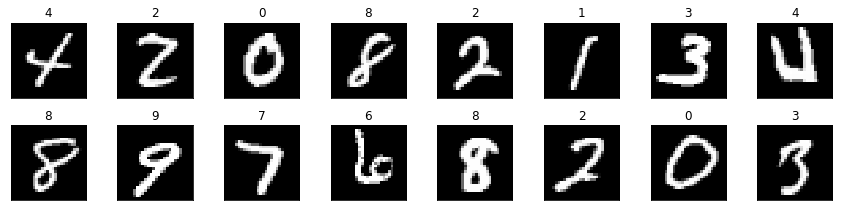

In [12]:
show_random_images(x_train_raw, y_train, 2, 8)
# show_random_images(x_test_raw, y_test)

In [13]:
x_train_deskewed = np.apply_along_axis(deskew_image, arr=x_train_raw, axis=1)
x_test_deskewed = np.apply_along_axis(deskew_image, arr=x_test_raw, axis=1)

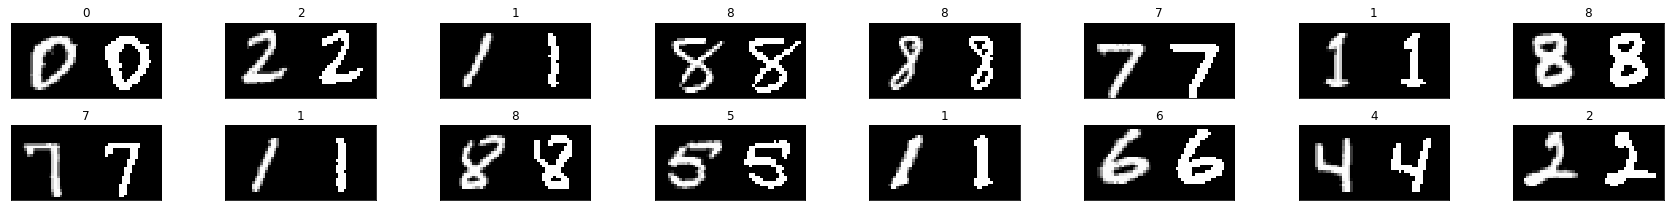

In [14]:
show_random_diff(x_train_raw, x_train_deskewed, y_train, 2, 8)
# show_random_diff(x_test_raw, x_test_deskewed, y_test, 5, 5)

In [15]:
x_train_raw = x_train_raw.reshape(-1, 28, 28, n_channels)/255.
x_test_raw = x_test_raw.reshape(-1, 28, 28, n_channels)/255.

x_train_deskewed = x_train_deskewed.reshape(-1, 28, 28, n_channels)/255.
x_test_deskewed = x_test_deskewed.reshape(-1, 28, 28, n_channels)/255.

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [16]:
def build_model():
    model= Sequential()

    model.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same',activation='relu', 
                     data_format='channels_last', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
model_1 = build_model()
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [18]:
history_1 = model_1.fit(x_train_raw, y_train, validation_data=(x_test_raw, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 31s 517us/step - loss: 0.2507 - acc: 0.9226 - val_loss: 0.0747 - val_acc: 0.9761
Epoch 2/5
60000/60000 [==============================] - 27s 450us/step - loss: 0.0770 - acc: 0.9770 - val_loss: 0.0698 - val_acc: 0.9774
Epoch 3/5
60000/60000 [==============================] - 26s 439us/step - loss: 0.0538 - acc: 0.9827 - val_loss: 0.0405 - val_acc: 0.9853
Epoch 4/5
60000/60000 [==============================] - 31s 522us/step - loss: 0.0439 - acc: 0.9865 - val_loss: 0.0514 - val_acc: 0.9844
Epoch 5/5
60000/60000 [==============================] - 28s 474us/step - loss: 0.0362 - acc: 0.9883 - val_loss: 0.0310 - val_acc: 0.9895


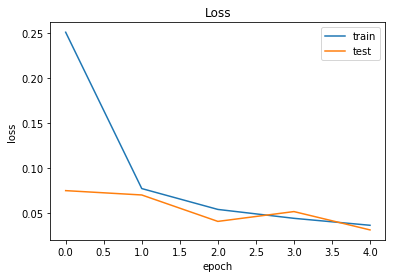

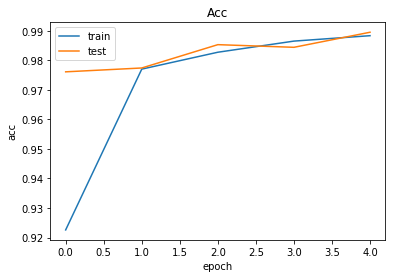

In [19]:
plot_history(history_1)

In [20]:
acc_1 = 100 * model_1.evaluate(x_test_raw, y_test, verbose=0)[1]
print('Model 1 acc: %0.3f%%' % acc_1)

Model 1 acc: 98.950%


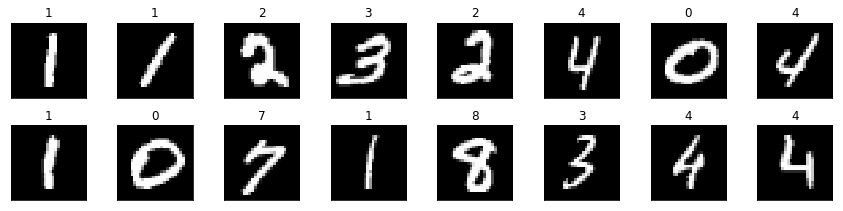

In [21]:
predict_random_images(x_test_raw, model_1, 2, 8)

In [23]:
model_2 = build_model()
history_2 = model_2.fit(x_train_deskewed, y_train, validation_data=(x_test_deskewed, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 30s 498us/step - loss: 0.1968 - acc: 0.9404 - val_loss: 0.0908 - val_acc: 0.9702
Epoch 2/5
60000/60000 [==============================] - 28s 471us/step - loss: 0.0654 - acc: 0.9796 - val_loss: 0.0666 - val_acc: 0.9781
Epoch 3/5
60000/60000 [==============================] - 28s 474us/step - loss: 0.0500 - acc: 0.9838 - val_loss: 0.0434 - val_acc: 0.9853
Epoch 4/5
60000/60000 [==============================] - 28s 465us/step - loss: 0.0413 - acc: 0.9869 - val_loss: 0.0403 - val_acc: 0.9859
Epoch 5/5
60000/60000 [==============================] - 28s 470us/step - loss: 0.0346 - acc: 0.9888 - val_loss: 0.0307 - val_acc: 0.9901


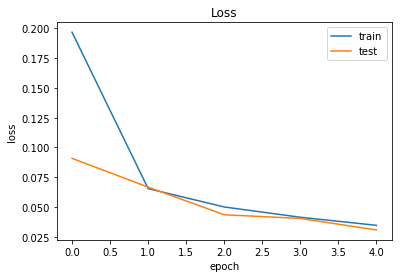

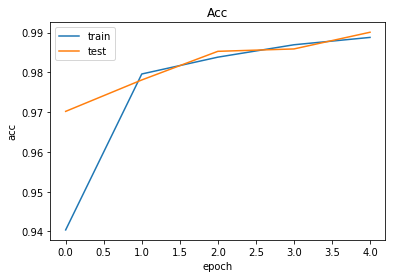

In [24]:
plot_history(history_2)

In [29]:
acc_2 = 100 * model_2.evaluate(x_test_deskewed, y_test, verbose=0)[1]
print('Model 2 acc: %0.3f%%' % acc_2)

Model 2 acc: 99.010%


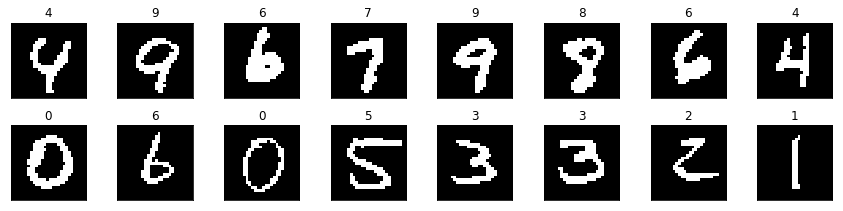

In [30]:
predict_random_images(x_test_deskewed, model_2, 2, 8)